# COMP4318/5318 Assignment 2: Image Classification

### Group number: A2 group 110 , SID1: 540151084, SID2: 540179789

## Setup and dependencies

In [1]:
# load the libraries
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import itertools
import time
from tqdm import tqdm
from IPython.display import display, Markdown
import warnings
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from tensorflow.keras import layers, regularizers
import random
import warnings
warnings.filterwarnings('ignore')
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.19.0
Keras version: 3.9.2


## 1. Data loading, exploration, and preprocessing

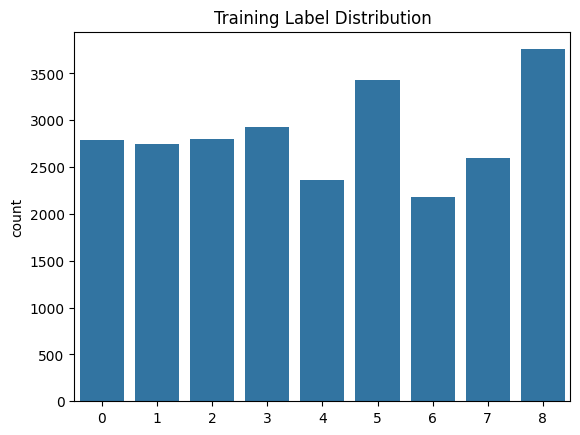

In [17]:
# load the dataset
X_train = np.load('X_train.npy').astype('float32') / 255.0
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy').astype('float32') / 255.0
y_test = np.load('y_test.npy')

# validate the dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# visualize the dataset
sns.countplot(x=y_train)
plt.title("Training Label Distribution")
plt.show()

### Examples of preprocessed data

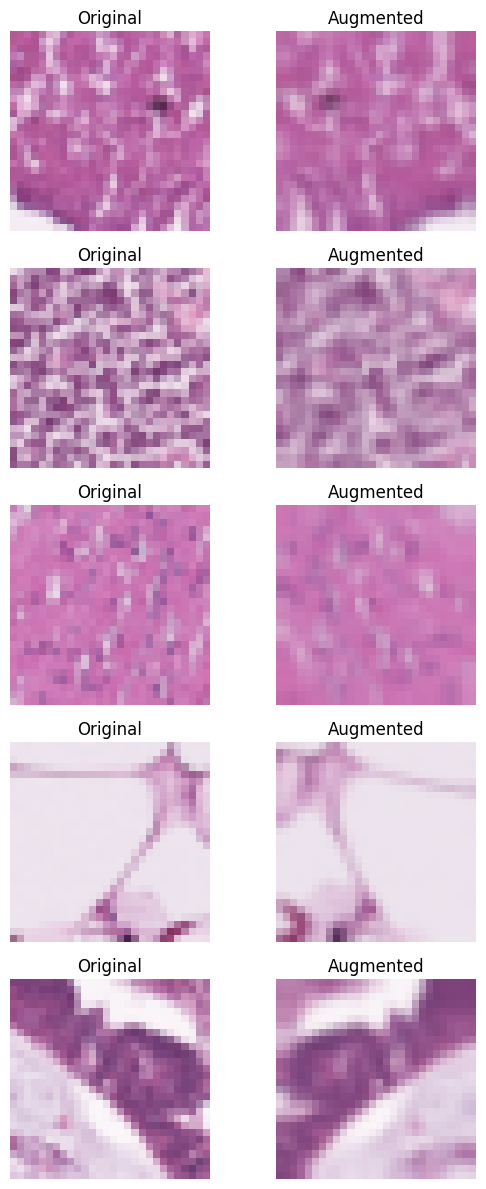

In [18]:
# augment the dataset
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
# visualize the augmentation
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
for i in range(5):
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title("Original")

    augmented = data_augmentation(tf.expand_dims(X_train[i], 0))
    axes[i, 1].imshow(augmented[0].numpy())
    axes[i, 1].set_title("Augmented")

    for j in [0, 1]:
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()

## 2. Algorithm design and setup

### Random Forest

RF: n=10, Val Acc=0.4981
RF: n=50, Val Acc=0.6131
RF: n=100, Val Acc=0.6403
RF: n=200, Val Acc=0.6508

 RF Test Accuracy: 0.643125
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       873
           1       0.97      0.90      0.94       858
           2       0.69      0.30      0.41       877
           3       0.78      0.90      0.83       914
           4       0.68      0.55      0.61       737
           5       0.53      0.63      0.58      1072
           6       0.49      0.12      0.19       682
           7       0.52      0.41      0.46       813
           8       0.47      0.81      0.60      1174

    accuracy                           0.64      8000
   macro avg       0.66      0.62      0.61      8000
weighted avg       0.65      0.64      0.62      8000



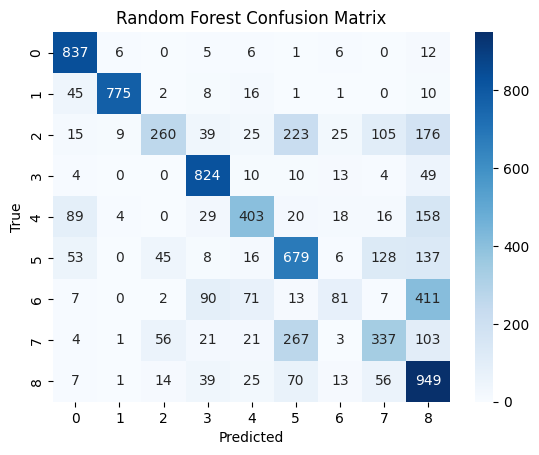

In [ ]:
# Random Forest Classifier With PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)
# apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

best_acc, best_n = 0, 10
for n in [10, 50, 100, 200]:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_pca, y_train)
    acc = accuracy_score(y_val, rf.predict(X_val_pca))
    print(f"RF: n={n}, Val Acc={acc:.4f}")
    if acc > best_acc:
        best_acc, best_n = acc, n
#     print(f"Best RF: n={best_n}, Val Acc={best_acc:.4f}")
rf_best = RandomForestClassifier(n_estimators=best_n, random_state=42)
rf_best.fit(X_train_pca, y_train)
rf_preds = rf_best.predict(X_test_pca)
print("\n RF Test Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### MLP

In [ ]:
# MLP with PCA
mlp = keras.Sequential([
    layers.Input(shape=(X_train_pca.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])
# compile the MLP model
mlp.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

history = mlp.fit(
    X_train_pca, y_train,
    validation_data=(X_val_pca, y_val),
    epochs=20,
    batch_size=32
)

# test the MLP model
mlp_test_loss, mlp_test_acc = mlp.evaluate(X_test_pca, y_test)
print(f"\n MLP Test Accuracy: {mlp_test_acc:.4f}")

y_pred_mlp = np.argmax(mlp.predict(X_test_pca), axis=1)
print(classification_report(y_test, y_pred_mlp))

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3504 - loss: 1.9804 - val_accuracy: 0.5377 - val_loss: 1.2338
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4893 - loss: 1.3148 - val_accuracy: 0.5653 - val_loss: 1.1710
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5270 - loss: 1.2250 - val_accuracy: 0.5747 - val_loss: 1.1232
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5487 - loss: 1.1654 - val_accuracy: 0.5838 - val_loss: 1.1061
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5638 - loss: 1.1301 - val_accuracy: 0.5903 - val_loss: 1.0717
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5756 - loss: 1.1062 - val_accuracy: 0.5983 - val_loss: 1.0704
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5850 - loss: 1.0893 - val_accuracy: 0.6167 - val_loss: 1.0317
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5871 - loss: 1.0694 - val_accuracy: 0.

### CNN

In [ ]:
# CNN with augmentation
cnn = keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    data_augmentation,
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])
# compile the CNN model
cnn.compile(optimizer=keras.optimizers.Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
# fit the CNN model
cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)
# test the CNN model
cnn_test_loss, cnn_test_acc = cnn.evaluate(X_test, y_test)
print(f"\n CNN Test Accuracy: {cnn_test_acc:.4f}")

y_pred_cnn = np.argmax(cnn.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_cnn))

Epoch 1/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3099 - loss: 1.7900 - val_accuracy: 0.5911 - val_loss: 1.1034
Epoch 2/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5593 - loss: 1.1726 - val_accuracy: 0.5727 - val_loss: 1.1218
Epoch 3/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6156 - loss: 1.0373 - val_accuracy: 0.6586 - val_loss: 0.9226
Epoch 4/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6428 - loss: 0.9527 - val_accuracy: 0.6575 - val_loss: 0.8915
Epoch 5/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6666 - loss: 0.9156 - val_accuracy: 0.6539 - val_loss: 0.9232
Epoch 6/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6893 - loss: 0.8437 - val_accuracy: 0.7200 - val_loss: 0.7577
Epoch 7/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6982 - loss: 0.8384 - val_accuracy: 0.6445 - val_loss: 0.9554
Epoch 8/15
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7036 - loss: 0.8074 - val_accuracy: 0.

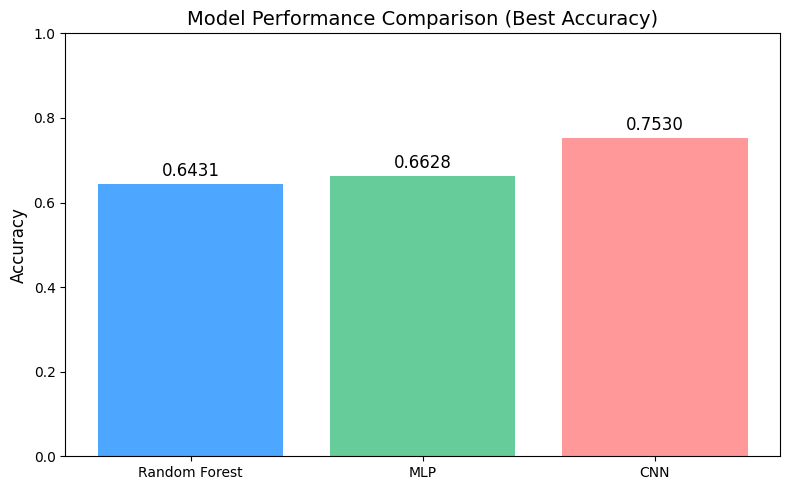

In [ ]:
# Compare the best accuracies of the three models
models = ['Random Forest', 'MLP', 'CNN']
accuracies = [accuracy_score(y_test, rf_preds), mlp_test_acc, cnn_test_acc]
# Plot the accuracies
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['#4da6ff', '#66cc99', '#ff9999'])
plt.title("Model Performance Comparison (Best Accuracy)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
# Add accuracy values on top of the bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{acc:.4f}",
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Hyperparameter tuning

### Random Forest

 Starting RandomizedSearchCV...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
 RandomizedSearchCV Complete! Total Time: 831.61 seconds (13.86 minutes)

 Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 30, 'rf__bootstrap': False}
 Best CV Balanced Accuracy: 0.6305

 Training Best Model on Combined Data...
 Best Model Training Time on Combined Data: 232.9577 seconds (3.8826 minutes)

 Final Test Accuracy: 0.6561
 Final Test Balanced Accuracy: 0.6347
 Best Model Prediction Time on Test Set: 0.2722 seconds (0.0045 minutes)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       873
           1       0.98      0.90      0.94       858
           2       0.71      0.33      0.45       877
           3       0.79      0.91      0.84       914
           4       0.69      0.56      0.62       737
           5    

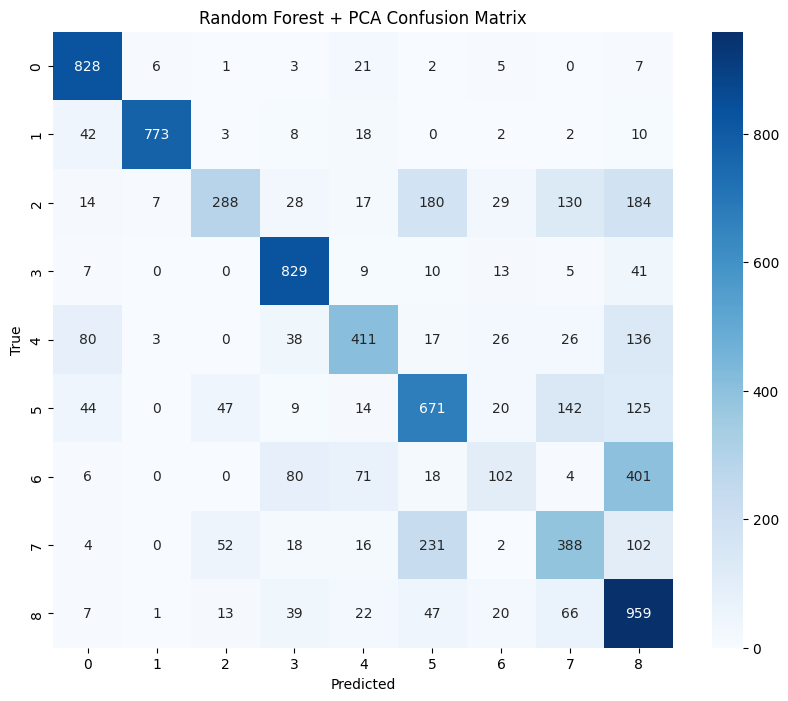


 Top 5 Parameter Combinations:
                                               params  mean_test_score  \
24  {'rf__n_estimators': 200, 'rf__min_samples_spl...         0.630532   
16  {'rf__n_estimators': 200, 'rf__min_samples_spl...         0.630337   
4   {'rf__n_estimators': 300, 'rf__min_samples_spl...         0.629810   
27  {'rf__n_estimators': 200, 'rf__min_samples_spl...         0.629052   
25  {'rf__n_estimators': 300, 'rf__min_samples_spl...         0.627639   

    rank_test_score  
24                1  
16                2  
4                 3  
27                4  
25                5  


In [11]:
# Randomized Search for Hyperparameter Tuning with PCA + RF

# Flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Combine training + validation for final tuning
X_combined = np.vstack([X_train_flat, X_val_flat])
y_combined = np.concatenate([y_train, y_val])

# Build pipeline: scaling + PCA + RF
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define parameter search space
param_distributions = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,  # Number of random combinations
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print(" Starting RandomizedSearchCV...")
start_time = time.time()  # Start total timing
random_search.fit(X_combined, y_combined)
end_time = time.time()  # End total timing
runtime_sec = end_time - start_time
print(f" RandomizedSearchCV Complete! Total Time: {runtime_sec:.2f} seconds ({runtime_sec / 60:.2f} minutes)")

# Best results
print("\n Best Parameters:", random_search.best_params_)
print(f" Best CV Balanced Accuracy: {random_search.best_score_:.4f}")

# ==== Train best model separately and record train time ====
best_model = random_search.best_estimator_

print("\n Training Best Model on Combined Data...")
best_train_start = time.time()
best_model.fit(X_combined, y_combined)
best_train_end = time.time()
best_train_time = best_train_end - best_train_start
print(f" Best Model Training Time on Combined Data: {best_train_time:.4f} seconds ({best_train_time / 60:.4f} minutes)")

# ==== Evaluate best model on test set ====
X_test_scaled_pca = best_model.named_steps['pca'].transform(
    best_model.named_steps['scaler'].transform(X_test_flat)
)

# Timing prediction
test_start_time = time.time()
test_preds = best_model.named_steps['rf'].predict(X_test_scaled_pca)
test_end_time = time.time()
test_runtime_sec = test_end_time - test_start_time

test_acc = accuracy_score(y_test, test_preds)
test_bal_acc = balanced_accuracy_score(y_test, test_preds)

print(f"\n Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f" Best Model Prediction Time on Test Set: {test_runtime_sec:.4f} seconds ({test_runtime_sec / 60:.4f} minutes)")

print("\nClassification Report:")
print(classification_report(y_test, test_preds))

# Confusion matrix plot
conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest + PCA Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Show top parameter combinations and scores
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df.sort_values(by='mean_test_score', ascending=False)[
    ['params', 'mean_test_score', 'rank_test_score']
].head(5)
print("\n Top 5 Parameter Combinations:")
print(top_results)

### MLP

PCA reduced dimensions: 342


Grid Search Progress:   6%|▋         | 1/16 [00:16<04:11, 16.77s/it]

 [1/16] lr=0.01, h1=256, h2=128, bs=32 → Val Acc: 0.5412, Test Acc: 0.5404, Time: 16.36s


Grid Search Progress:  12%|█▎        | 2/16 [00:29<03:21, 14.39s/it]

 [2/16] lr=0.01, h1=256, h2=128, bs=64 → Val Acc: 0.6308, Test Acc: 0.6321, Time: 12.45s


Grid Search Progress:  19%|█▉        | 3/16 [00:35<02:14, 10.38s/it]

 [3/16] lr=0.01, h1=256, h2=256, bs=32 → Val Acc: 0.4778, Test Acc: 0.4780, Time: 5.37s


Grid Search Progress:  25%|██▌       | 4/16 [00:42<01:49,  9.15s/it]

 [4/16] lr=0.01, h1=256, h2=256, bs=64 → Val Acc: 0.5761, Test Acc: 0.5754, Time: 6.97s


Grid Search Progress:  31%|███▏      | 5/16 [00:49<01:32,  8.39s/it]

 [5/16] lr=0.01, h1=512, h2=128, bs=32 → Val Acc: 0.4133, Test Acc: 0.4132, Time: 6.79s


Grid Search Progress:  38%|███▊      | 6/16 [01:05<01:51, 11.15s/it]

 [6/16] lr=0.01, h1=512, h2=128, bs=64 → Val Acc: 0.6087, Test Acc: 0.6064, Time: 16.23s


Grid Search Progress:  44%|████▍     | 7/16 [01:15<01:35, 10.61s/it]

 [7/16] lr=0.01, h1=512, h2=256, bs=32 → Val Acc: 0.4239, Test Acc: 0.4199, Time: 9.23s


Grid Search Progress:  50%|█████     | 8/16 [01:34<01:45, 13.22s/it]

 [8/16] lr=0.01, h1=512, h2=256, bs=64 → Val Acc: 0.6225, Test Acc: 0.6143, Time: 18.52s


Grid Search Progress:  56%|█████▋    | 9/16 [01:53<01:45, 15.13s/it]

 [9/16] lr=0.001, h1=256, h2=128, bs=32 → Val Acc: 0.6681, Test Acc: 0.6697, Time: 19.09s


Grid Search Progress:  62%|██████▎   | 10/16 [02:05<01:25, 14.21s/it]

 [10/16] lr=0.001, h1=256, h2=128, bs=64 → Val Acc: 0.6727, Test Acc: 0.6671, Time: 11.87s


Grid Search Progress:  69%|██████▉   | 11/16 [02:25<01:20, 16.03s/it]

 [11/16] lr=0.001, h1=256, h2=256, bs=32 → Val Acc: 0.6678, Test Acc: 0.6814, Time: 19.94s


Grid Search Progress:  75%|███████▌  | 12/16 [02:36<00:57, 14.32s/it]

 [12/16] lr=0.001, h1=256, h2=256, bs=64 → Val Acc: 0.6628, Test Acc: 0.6701, Time: 10.12s


Grid Search Progress:  81%|████████▏ | 13/16 [03:02<00:54, 18.06s/it]

 [13/16] lr=0.001, h1=512, h2=128, bs=32 → Val Acc: 0.6672, Test Acc: 0.6745, Time: 26.43s


Grid Search Progress:  88%|████████▊ | 14/16 [03:20<00:35, 17.80s/it]

 [14/16] lr=0.001, h1=512, h2=128, bs=64 → Val Acc: 0.6734, Test Acc: 0.6784, Time: 16.90s


Grid Search Progress:  94%|█████████▍| 15/16 [03:38<00:17, 17.98s/it]

 [15/16] lr=0.001, h1=512, h2=256, bs=32 → Val Acc: 0.6652, Test Acc: 0.6670, Time: 18.14s


Grid Search Progress: 100%|██████████| 16/16 [03:52<00:00, 14.56s/it]

 [16/16] lr=0.001, h1=512, h2=256, bs=64 → Val Acc: 0.6689, Test Acc: 0.6741, Time: 14.15s

 Best MLP Parameters:
Learning Rate: 0.001, Hidden1: 512, Hidden2: 128, Batch Size: 64
Best Validation Accuracy: 0.6734
Corresponding Test Accuracy: 0.6784
Total Grid Search Time: 3.88 minutes

 Top 5 Results:
    learning_rate  hidden1  hidden2  batch_size  val_accuracy  test_accuracy  \
13          0.001      512      128          64      0.673437       0.678375   
9           0.001      256      128          64      0.672656       0.667125   
15          0.001      512      256          64      0.668906       0.674125   
8           0.001      256      128          32      0.668125       0.669750   
10          0.001      256      256          32      0.667813       0.681375   

      runtime  
13  16.897133  
9   11.874146  
15  14.145104  
8   19.091855  
10  19.935304  


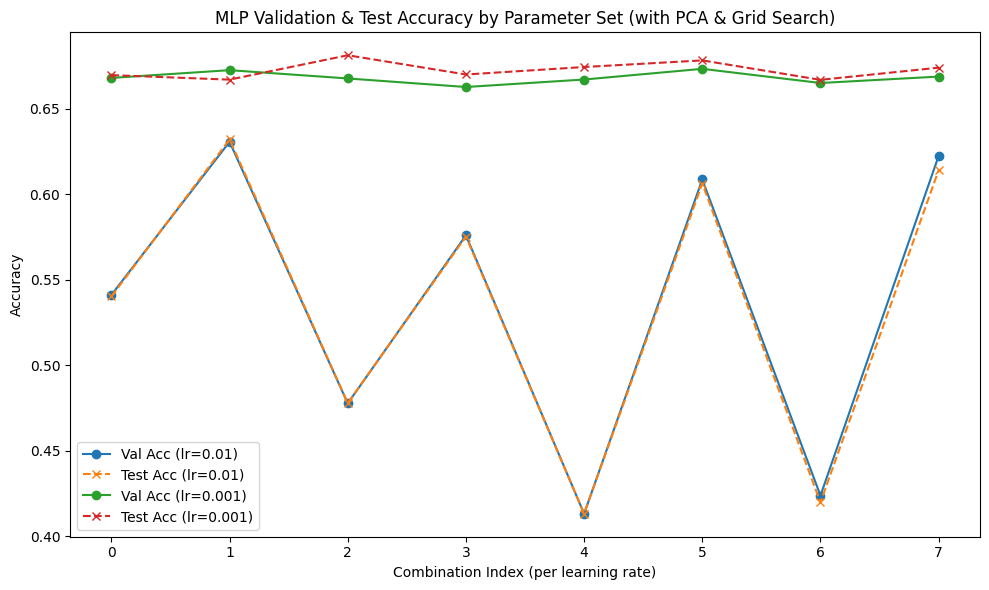

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# flatten & standardize
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

print(f"PCA reduced dimensions: {X_train_pca.shape[1]}")

# hyperparameter grid
learning_rates = [0.01, 0.001]
hidden1_list = [256, 512]
hidden2_list = [128, 256]
batch_sizes = [32, 64]
param_grid = list(itertools.product(learning_rates, hidden1_list, hidden2_list, batch_sizes))

results = []
best_acc = 0
best_params = None
best_test_acc = 0

total_start = time.time()

# tqdm progress bar
for idx, (lr, h1, h2, batch_size) in enumerate(tqdm(param_grid, desc="Grid Search Progress")):
    model = keras.Sequential([
        layers.Input(shape=(X_train_pca.shape[1],)),
        layers.Dense(h1, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(h2, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=0),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=0)
    ]

    start_time = time.time()
    history = model.fit(
        X_train_pca, y_train,
        validation_data=(X_val_pca, y_val),
        epochs=20,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )
    runtime = time.time() - start_time
    
    # Get best validation accuracy
    best_val_acc = max(history.history.get('val_accuracy', [0]))

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_pca, y_test, verbose=0)

    print(f" [{idx+1}/{len(param_grid)}] lr={lr}, h1={h1}, h2={h2}, bs={batch_size} → "
          f"Val Acc: {best_val_acc:.4f}, Test Acc: {test_acc:.4f}, Time: {runtime:.2f}s")

    results.append((lr, h1, h2, batch_size, best_val_acc, test_acc, runtime))

    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_params = (lr, h1, h2, batch_size)
        best_test_acc = test_acc
# total time for grid search
total_time = time.time() - total_start

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["learning_rate", "hidden1", "hidden2", "batch_size", "val_accuracy", "test_accuracy", "runtime"])

print("\n Best MLP Parameters:")
print(f"Learning Rate: {best_params[0]}, Hidden1: {best_params[1]}, Hidden2: {best_params[2]}, Batch Size: {best_params[3]}")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Corresponding Test Accuracy: {best_test_acc:.4f}")
print(f"Total Grid Search Time: {total_time / 60:.2f} minutes")

print("\n Top 5 Results:")
print(results_df.sort_values(by="val_accuracy", ascending=False).head())

# Plot validation and test accuracy
plt.figure(figsize=(10, 6))
for lr in results_df["learning_rate"].unique():
    subset = results_df[results_df["learning_rate"] == lr].reset_index()
    plt.plot(subset.index, subset["val_accuracy"], marker='o', label=f"Val Acc (lr={lr})")
    plt.plot(subset.index, subset["test_accuracy"], marker='x', linestyle='--', label=f"Test Acc (lr={lr})")

plt.title("MLP Validation & Test Accuracy by Parameter Set (with PCA & Grid Search)")
plt.xlabel("Combination Index (per learning rate)")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### CNN


Training CNN with conv1=32, conv2=32, kernel=(3, 3), dense=128, dropout=0.3, lr=0.001, batch_size=32, opt=rmsprop
 Best Val Accuracy: 0.6344 | Test Accuracy: 0.6355 | Time: 36.05s

Training CNN with conv1=16, conv2=128, kernel=(3, 3), dense=128, dropout=0.3, lr=0.001, batch_size=64, opt=adam
 Best Val Accuracy: 0.8238 | Test Accuracy: 0.8180 | Time: 50.69s

Training CNN with conv1=16, conv2=128, kernel=(5, 5), dense=256, dropout=0.5, lr=0.001, batch_size=64, opt=adam
 Best Val Accuracy: 0.7480 | Test Accuracy: 0.7455 | Time: 74.06s

Training CNN with conv1=16, conv2=32, kernel=(5, 5), dense=128, dropout=0.3, lr=0.001, batch_size=32, opt=sgd
 Best Val Accuracy: 0.5113 | Test Accuracy: 0.5154 | Time: 24.34s

Training CNN with conv1=32, conv2=64, kernel=(5, 5), dense=256, dropout=0.5, lr=0.01, batch_size=64, opt=rmsprop
 Best Val Accuracy: 0.5902 | Test Accuracy: 0.5909 | Time: 36.41s

Training CNN with conv1=16, conv2=64, kernel=(3, 3), dense=128, dropout=0.3, lr=0.001, batch_size=64, o

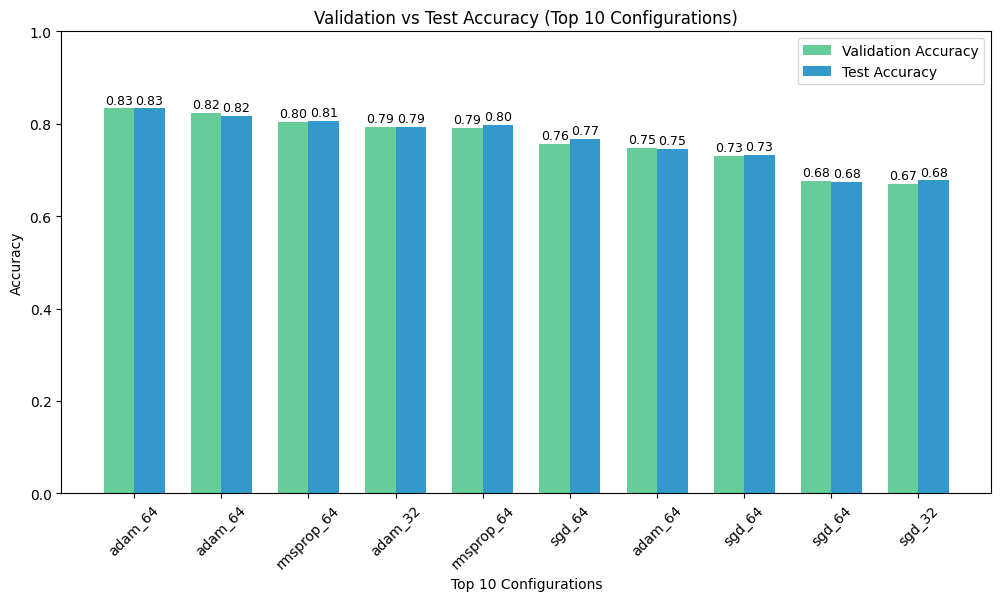

In [ ]:
# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# hyperparameter grid
conv1_list = [16, 32, 64]
conv2_list = [32, 64, 128]
kernel_sizes = [(3, 3), (5, 5)]
dense_units = [128, 256]
dropout_rates = [0.3, 0.5]
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
optimizers = ['adam', 'rmsprop', 'sgd']

# randomly sample combinations
param_combinations = list(itertools.product(conv1_list, conv2_list, kernel_sizes, dense_units,
                                            dropout_rates, learning_rates, batch_sizes, optimizers))
sampled_params = random.sample(param_combinations, 20)

results = []
best_acc = 0
best_params = None
best_test_acc = 0

# augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

for params in sampled_params:
    conv1_out, conv2_out, kernel_size, dense_unit, dropout_rate, lr, batch_size, optimizer_name = params
    print(f"\nTraining CNN with conv1={conv1_out}, conv2={conv2_out}, kernel={kernel_size}, "
          f"dense={dense_unit}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}, opt={optimizer_name}")

    start_time = time.time()

    # set optimizer
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

    # define CNN model
    cnn = keras.Sequential([
        data_augmentation,
        layers.Conv2D(conv1_out, kernel_size, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.AveragePooling2D(2, 2),
        layers.Conv2D(conv2_out, kernel_size, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_unit, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(len(np.unique(y_train)), activation='softmax')
    ])
    # compile the CNN model
    cnn.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=0),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=0)
    ]

    history = cnn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )

    end_time = time.time()
    runtime = end_time - start_time
    best_val_acc = max(history.history['val_accuracy'])

    # Evaluate on test set
    test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=0)

    print(f" Best Val Accuracy: {best_val_acc:.4f} | Test Accuracy: {test_acc:.4f} | Time: {runtime:.2f}s")

    results.append((conv1_out, conv2_out, kernel_size, dense_unit, dropout_rate, lr,
                    batch_size, optimizer_name, best_val_acc, test_acc, runtime))
    # save the best model
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_params = (conv1_out, conv2_out, kernel_size, dense_unit, dropout_rate, lr,
                       batch_size, optimizer_name)
        best_test_acc = test_acc

# report the best parameters
print("\n Best CNN Parameters:")
print(f"Conv1: {best_params[0]}, Conv2: {best_params[1]}, Kernel Size: {best_params[2]}, Dense: {best_params[3]}, "
      f"Dropout: {best_params[4]}, Learning Rate: {best_params[5]}, Batch Size: {best_params[6]}, Optimizer: {best_params[7]}")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Corresponding Test Accuracy: {best_test_acc:.4f}")

# save results
results_df = pd.DataFrame(results, columns=[
    "conv1_out", "conv2_out", "kernel_size", "dense_units", "dropout_rate",
    "learning_rate", "batch_size", "optimizer", "val_accuracy", "test_accuracy", "runtime_sec"
])
results_df = results_df.sort_values(by="val_accuracy", ascending=False)

print("\n Top 5 Results:")
print(results_df.head())

# visualize validation and test accuracy
top_df = results_df.head(10).reset_index()
plt.figure(figsize=(12, 6))
x = np.arange(len(top_df))
width = 0.35

plt.bar(x - width/2, top_df['val_accuracy'], width, label='Validation Accuracy', color='#66cc99')
plt.bar(x + width/2, top_df['test_accuracy'], width, label='Test Accuracy', color='#3399cc')

plt.xlabel('Top 10 Configurations')
plt.ylabel('Accuracy')
plt.title('Validation vs Test Accuracy (Top 10 Configurations)')
plt.ylim(0, 1)
plt.xticks(x, [f"{opt}_{bs}" for opt, bs in zip(top_df['optimizer'], top_df['batch_size'])], rotation=45)
plt.legend()
# plt.tight_layout()
for i in range(len(top_df)):
    plt.text(x[i] - width/2, top_df['val_accuracy'][i] + 0.01, f"{top_df['val_accuracy'][i]:.2f}", ha='center', fontsize=9)
    plt.text(x[i] + width/2, top_df['test_accuracy'][i] + 0.01, f"{top_df['test_accuracy'][i]:.2f}", ha='center', fontsize=9)



### Model Comparison Summary ###

        Model                                                                                                                                              Best Parameters  Best Validation Accuracy  Final Test Accuracy  Best Train Time (sec)
Random Forest                            {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}                    0.6305               0.6561               232.9577
          MLP                                                                                   {'learning_rate': 0.001, 'hidden1': 512, 'hidden2': 128, 'batch_size': 64}                    0.6734               0.6784                16.8971
          CNN {'conv1_out': 16, 'conv2_out': 64, 'kernel_size': (3, 3), 'dense_units': 128, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'adam'}                    0.8334               0.8335                53.1978


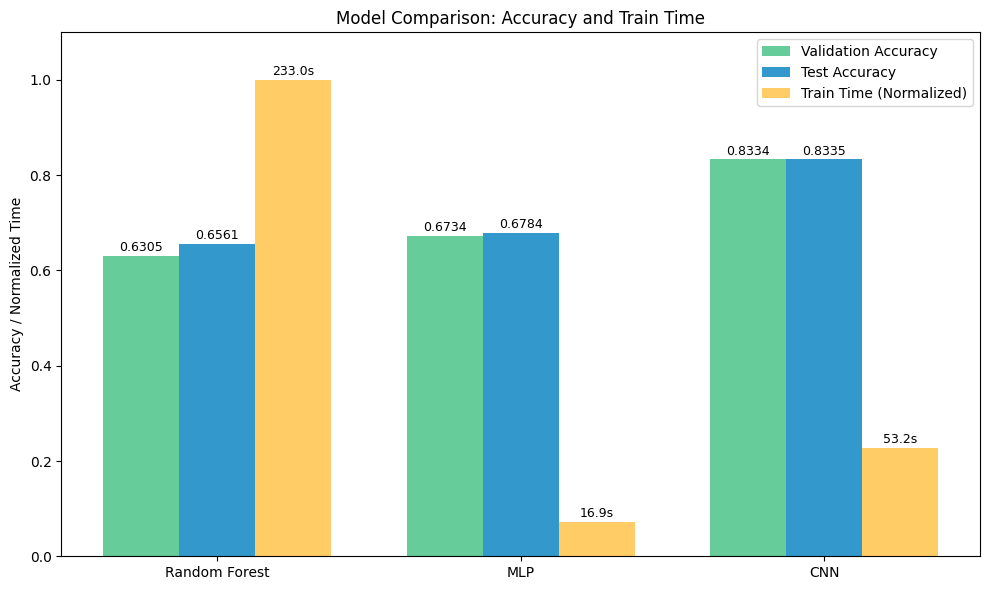

In [ ]:
# Model Comparison Summary
# Data
models = ['Random Forest', 'MLP', 'CNN']
best_params = [
    {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False},
    {'learning_rate': 0.001, 'hidden1': 512, 'hidden2': 128, 'batch_size': 64},
    {'conv1_out': 16, 'conv2_out': 64, 'kernel_size': (3, 3), 'dense_units': 128, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'adam'}
]
val_accuracies = [0.6305, 0.6734, 0.8334]
test_accuracies = [0.6561, 0.6784, 0.8335]
train_times = [232.9577, 16.8971, 53.1978]  # in seconds

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Model': models,
    'Best Parameters': best_params,
    'Best Validation Accuracy': val_accuracies,
    'Final Test Accuracy': test_accuracies,
    'Best Train Time (sec)': train_times
})

print("\n### Model Comparison Summary ###\n")
print(summary_df.to_string(index=False))

# Plot grouped bars: Validation Accuracy, Test Accuracy, Train Time (normalized)
x = np.arange(len(models))
width = 0.25

# Normalize train times for plotting
max_train_time = max(train_times)
normalized_train_times = [t / max_train_time for t in train_times]

plt.figure(figsize=(10, 6))
plt.bar(x - width, val_accuracies, width, label='Validation Accuracy', color='#66cc99')
plt.bar(x, test_accuracies, width, label='Test Accuracy', color='#3399cc')
plt.bar(x + width, normalized_train_times, width, label='Train Time (Normalized)', color='#ffcc66')

plt.ylabel('Accuracy / Normalized Time')
plt.title('Model Comparison: Accuracy and Train Time')
plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.legend()

# Add value labels
for i in range(len(models)):
    plt.text(x[i] - width, val_accuracies[i] + 0.01, f"{val_accuracies[i]:.4f}", ha='center', fontsize=9)
    plt.text(x[i], test_accuracies[i] + 0.01, f"{test_accuracies[i]:.4f}", ha='center', fontsize=9)
    plt.text(x[i] + width, normalized_train_times[i] + 0.01, f"{train_times[i]:.1f}s", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


## 4. Final models


Training final Random Forest model with best parameters...
Training time: 231.27 seconds

Evaluating on test set...
Test Accuracy: 0.6561
Test Balanced Accuracy: 0.6347
Prediction Time on Test Set: 0.2695 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       873
           1       0.98      0.90      0.94       858
           2       0.71      0.33      0.45       877
           3       0.79      0.91      0.84       914
           4       0.69      0.56      0.62       737
           5       0.57      0.63      0.60      1072
           6       0.47      0.15      0.23       682
           7       0.51      0.48      0.49       813
           8       0.49      0.82      0.61      1174

    accuracy                           0.66      8000
   macro avg       0.67      0.63      0.63      8000
weighted avg       0.66      0.66      0.64      8000



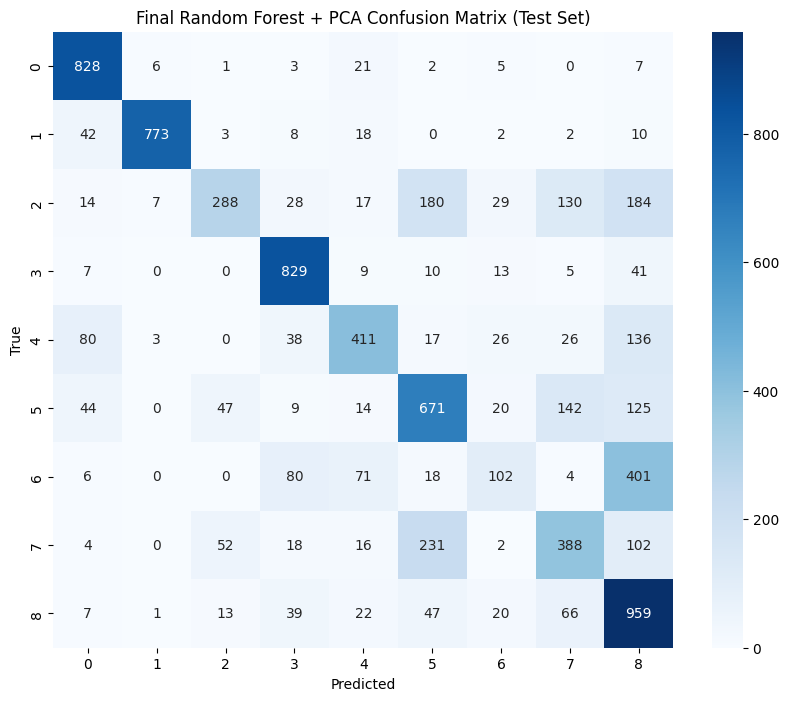

In [ ]:
#Random Forest 

np.random.seed(42)
tf.random.set_seed(42)
# Flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Combine training + validation (same as RandomizedSearchCV input)
X_combined = np.vstack([X_train_flat, X_val_flat])
y_combined = np.concatenate([y_train, y_val])

# Scale and apply PCA
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)
X_test_scaled = scaler.transform(X_test_flat)

pca = PCA(n_components=0.95, random_state=42)
X_combined_pca = pca.fit_transform(X_combined_scaled)
X_test_pca = pca.transform(X_test_scaled)

# ===== BEST PARAMETERS from previous search =====
best_rf_params = {
    'n_estimators': 200,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': False,
}

# ==== Train model ====
print("\nTraining final Random Forest model with best parameters...")
start_time = time.time()
final_rf_model = RandomForestClassifier(**best_rf_params)
final_rf_model.fit(X_combined_pca, y_combined)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# ==== Evaluate on test set ====
print("\nEvaluating on test set...")
test_start = time.time()
test_preds = final_rf_model.predict(X_test_pca)
test_end = time.time()
test_runtime = test_end - test_start

test_acc = accuracy_score(y_test, test_preds)
test_bal_acc = balanced_accuracy_score(y_test, test_preds)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"Prediction Time on Test Set: {test_runtime:.4f} seconds")

print("\nClassification Report:")
print(classification_report(y_test, test_preds))

# ==== Confusion Matrix ====
conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Final Random Forest + PCA Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

PCA reduced dimensions: 342
Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4108 - loss: 1.6652 - val_accuracy: 0.6053 - val_loss: 1.0702
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5872 - loss: 1.0894 - val_accuracy: 0.6389 - val_loss: 0.9766
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6360 - loss: 0.9713 - val_accuracy: 0.6500 - val_loss: 0.9471
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6647 - loss: 0.8838 - val_accuracy: 0.6540 - val_loss: 0.9436
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6932 - loss: 0.8117 - val_accuracy: 0.6647 - val_loss: 0.9393
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7056 - loss: 0.7718 - val_accuracy: 0.6720 - val_loss: 0.9355
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7229 - loss: 0.7224 - val_accuracy: 0.6666 - val_loss: 0.9475
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7444 - los

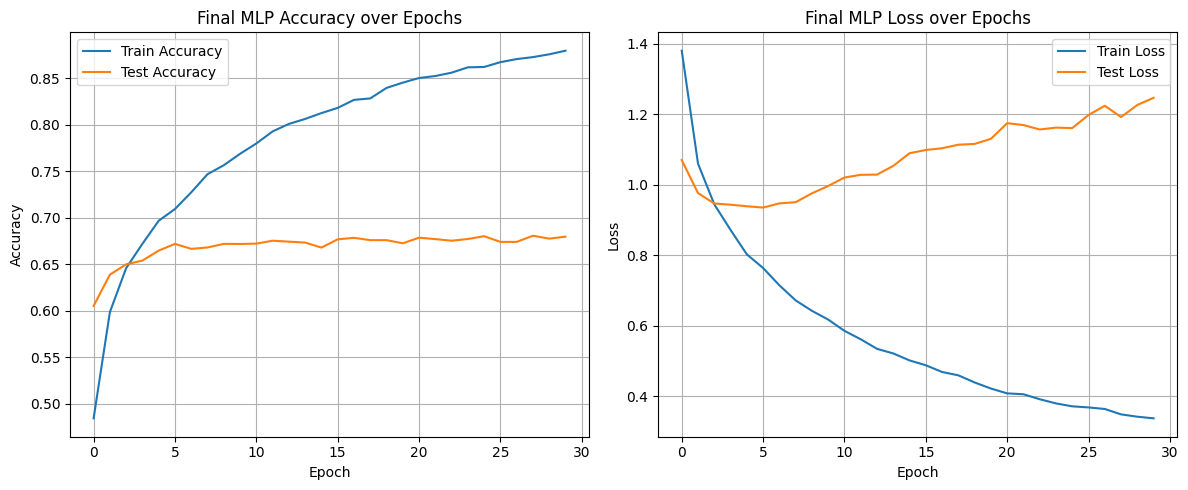

In [ ]:
# MLP
# Set seed
np.random.seed(42)
tf.random.set_seed(42)

# Flatten & standardize
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_test_std = scaler.transform(X_test_flat)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)

# Combine train + val
X_combined_pca = np.vstack([X_train_pca, X_val_pca])
y_combined = np.concatenate([y_train, y_val])

print(f"PCA reduced dimensions: {X_train_pca.shape[1]}")

# === Best hyperparameters from previous search ===
best_mlp_params = {
    'learning_rate': 0.001,
    'hidden1': 512,
    'hidden2': 128,
    'batch_size': 64
}

# Build final MLP model
final_mlp = keras.Sequential([
    layers.Input(shape=(X_combined_pca.shape[1],)),
    layers.Dense(best_mlp_params['hidden1'], activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(best_mlp_params['hidden2'], activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

final_mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_mlp_params['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train final model
history = final_mlp.fit(
    X_combined_pca, y_combined,
    validation_data=(X_test_pca, y_test),
    epochs=30,
    batch_size=best_mlp_params['batch_size'],
    verbose=1
)

# Evaluate on test set
mlp_test_loss, mlp_test_acc = final_mlp.evaluate(X_test_pca, y_test)
print(f"\nFinal MLP Test Accuracy: {mlp_test_acc:.4f}")

print("\nClassification Report (Test Set):")
y_test_pred = np.argmax(final_mlp.predict(X_test_pca), axis=1)
print(classification_report(y_test, y_test_pred))

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Final MLP Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Final MLP Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1325 - loss: 2.2210 - val_accuracy: 0.1468 - val_loss: 2.1772
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1424 - loss: 2.1889 - val_accuracy: 0.2306 - val_loss: 2.0400
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1813 - loss: 2.1291 - val_accuracy: 0.2929 - val_loss: 1.9787
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1927 - loss: 2.1028 - val_accuracy: 0.2131 - val_loss: 2.0248
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2085 - loss: 2.0503 - val_accuracy: 0.1951 - val_loss: 1.9790
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.2171 - loss: 2.0226 - val_accuracy: 0.3553 - val_loss: 1.8547
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2281 - loss: 2.0074 - val_accuracy: 0.3209 - val_loss: 1.8225
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.2333 - loss: 1.9865 - val_accu

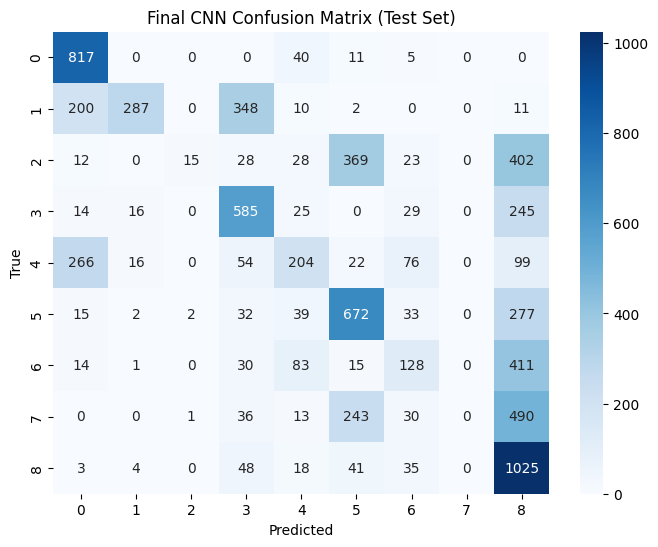

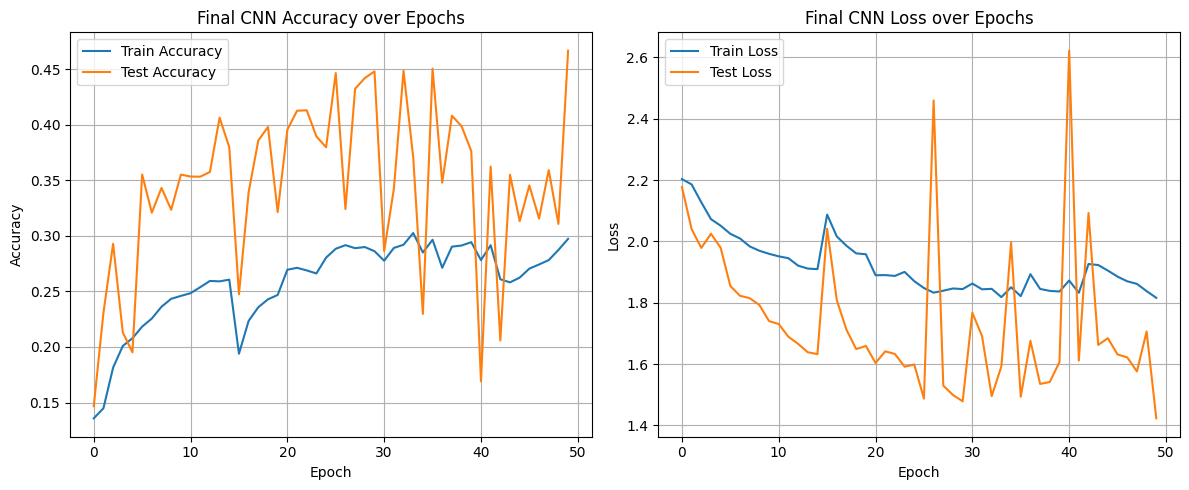

In [ ]:
# CNN
# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Combine train + val
X_combined = np.vstack([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# === Best hyperparameters from previous search ===
best_cnn_params = {
    'conv1_out': 16,
    'conv2_out': 64,
    'kernel_size': (3, 3),
    'dense_units': 128,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'batch_size': 64,
    'optimizer': 'adam'
}

# augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1)
])

# set optimizer
if best_cnn_params['optimizer'] == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=best_cnn_params['learning_rate'])
elif best_cnn_params['optimizer'] == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=best_cnn_params['learning_rate'])
else:
    optimizer = keras.optimizers.SGD(learning_rate=best_cnn_params['learning_rate'], momentum=0.9)

# define final CNN model
final_cnn = keras.Sequential([
    data_augmentation,
    layers.Conv2D(best_cnn_params['conv1_out'], best_cnn_params['kernel_size'], padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(best_cnn_params['conv2_out'], best_cnn_params['kernel_size'], padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(best_cnn_params['dense_units'], activation='relu'),
    layers.Dropout(best_cnn_params['dropout_rate']),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

final_cnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train final model
history = final_cnn.fit(
    X_combined, y_combined,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=best_cnn_params['batch_size'],
    verbose=1
)

# evaluate on test set
cnn_test_loss, cnn_test_acc = final_cnn.evaluate(X_test, y_test)
print(f"\nFinal CNN Test Accuracy: {cnn_test_acc:.4f}")

print("\nClassification Report (Test Set):")
y_test_pred = np.argmax(final_cnn.predict(X_test), axis=1)
print(classification_report(y_test, y_test_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Final CNN Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Final CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Final CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

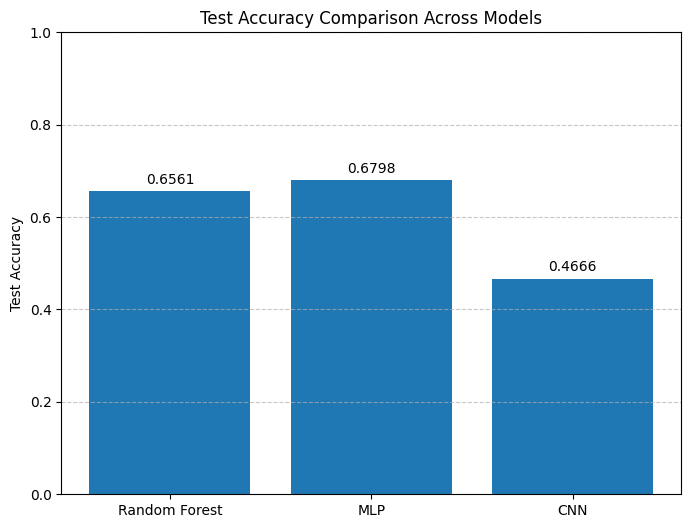

In [ ]:
# Compare the best accuracies of the three models
models = ['Random Forest', 'MLP', 'CNN']
accuracies = [0.6561, 0.6798, 0.4666]

# Plot the accuracies
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies)

# Add accuracy values on top of the bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{acc:.4f}", ha='center', va='bottom', fontsize=10)

# Set plot title and labels
plt.title('Test Accuracy Comparison Across Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
